# BayesNets in a Jupyter NoteBook (BNJNB) 

Ali Taylan Cemgil, 2018

Bogazici University

This notebook contains a self contained python implementation of the junction tree algorithm for exact inference in Bayesian networks with discrete probability tables. The aim is to provide a compact implementation so that the algorithms can be run in a notebook. 


# Bayesian Networks
A Bayesian Network is a probability model that has the form
$
\newcommand{\pa}[1]{ {\mathop{pa}({#1})}}
$
$$
p(x_{1:N}) = \prod_{n=1}^N p(x_n | x_\pa{n})
$$
The distribution is said to respect a directed acyclic graph (DAG) $\mathcal{G} = (V_\mathcal{G}, E_\mathcal{G})$ with $N$ nodes, where each random variable $x_n$ is associated with the node $n$ of $\mathcal{G}$. 

For each node $n$, the set of (possibly empty) parents nodes is denoted by $\pa{n}$. 

We assume that for each node $j$ in $\pa{n}$, we have a directed edge $j\rightarrow n$, denoted as the pair $(j,n)$. The edge set of $\mathcal{G}$ is the union of all such edges
$$
E_\mathcal{G} = \bigcup_{n \in [N]} \bigcup_{j \in \pa{n}} \{(j,n)\}
$$

To be associated with a proper probability model, the graph $G$ must be acyclic, that is it must be free of any directed cycles.


The elements of a Bayesian Network model are:

1. `alphabet`: 
      The alphabet is a set of strings for each random variable $x_n$ for $n \in [N]$. For each random variable $x_n$ that we include in our model (an observable or a hidden) we have a corresponding unique identifier in the alphabet. To enforce a user specified ordering, the `alphabet` is represented as a list `index_names` where `index_names[n]` is the string identifier for $x_n$. 

1. `parents`: 
    `parents` is a catalog that defines the edges of the directed acyclic graph $\mathcal{G}$. For each random variable $x_n$, we specify the set of parents $\pa{n}$, the variables that directly effect $x_n$. Here, each element of the alphabet is a key, and `parents[index_names[n]]` = $\pa{n}$ is the parent list.

1. `states`: States is a catalog, where each key is a name from the alphabet and the value is a list of strings that specify a readable string with each state of the random variable. 

1. `cardinalities`:
    In a discrete model each random variable $x_n$ has $I_n$ possible states. The list `cardinalities` is ordered according to the order specified by `index_names` where `cardinalities[n]` = $I_n$. `cardinalities` and `states` must be consistent: `cardinalities[n] = len(states[index_names[n]]) `

1. `theta`: A catalog or list of conditional probability tables, indexed by $n =0 \dots N-1$ . Each table `theta[n]` is an array that has $N$ dimensions. The dimensions that are in $\{n\} \cup \pa{n}$ have a cardinality $I_n$. Rhe remaining dimensions have a cardinality of one, given by `cardinality[n]`.


## Utility Functions

In [2]:
import numpy as np
import scipy as sc
from scipy.special import gammaln
from scipy.special import digamma
%matplotlib inline

from itertools import combinations

import pygraphviz as pgv
from IPython.display import Image
from IPython.display import display

def normalize(A, axis=None):
    """Normalize a probability table along a specified axis"""
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def find(cond):
    """
        finds indices where the given condition is satisfied.
    """
    return list(np.where(cond)[0])


## Random structure and parameter generators

In [3]:
def random_alphabet(N=20, first_letter='A'):
    """Generates unique strings to be used as index_names"""
    if N<27:
        alphabet = [chr(i+ord(first_letter)) for i in range(N)]
    else:
        alphabet = ['X'+str(i) for i in range(N)]    
    return alphabet

def random_parents(alphabet, max_indeg=3):
    """Random DAG generation"""
    N = len(alphabet)
    print(alphabet)
    indeg = lambda: np.random.choice(range(1,max_indeg+1))
    parents = {a:[b for b in np.random.choice(alphabet[0:(1 if i==0 else i)], replace=False, size=min(indeg(),i))] for i,a in enumerate(alphabet)}
    return parents

def random_cardinalities(alphabet, cardinality_choices=[2,3,4,5]):
    """Random cardinalities"""
    return [np.random.choice(cardinality_choices) for a in alphabet]
    
def random_states(alphabet, cardinalities):
    """Generate labels for each state"""
    return {a:[a+"_state_"+str(u) for u in range(cardinalities[i])] for i,a in enumerate(alphabet)}
    
def random_observations(cardinalities, visibles):
    """
    Samples a tensor of the shape of visibles. This function does not sample 
    from the joint distribution implied by the graph and the probability tables
    """
    return np.random.choice(range(10), size=clique_shape(cardinalities, visibles))
 
def random_dirichlet_cp_table(gamma, cardinalities, n, pa_n):
    '''
        gamma : Dirichlet shape parameter
        cardinalities : List of number of states of each variable
        n, pa_n : Output a table of form p(n | pa_n ), n is an index, pa_n is the list of parents of n 
    '''
    N = len(cardinalities)
    cl_shape = clique_shape(cardinalities, [n]+pa_n)
    U = clique_prior_marginal(cardinalities, cl_shape)
    return normalize(np.random.gamma(shape=gamma*U, size=cl_shape), axis=n)

def random_cp_tables(index_names, cardinalities, parents, gamma):
    """
    Samples a set of conditional probability tables consistent with the factorization
    implied by the graph.
    """
    N = len(index_names)
    theta = [[]]*N
    for n,a in enumerate(index_names):
        theta[n] = random_dirichlet_cp_table(gamma, cardinalities, n, index_names_to_num(index_names, parents[a]))
        #print(a, parents[a])
        #print(theta[n].shape)
        #print('--')
    return theta

def random_model(N=10, max_indeg=4):
    """
    Generates a random Bayesian Network
    """
    index_names = random_alphabet(N)
    parents = random_parents(index_names)
    cardinalities = random_cardinalities(index_names)
    states = random_states(index_names, cardinalities)
    
    return index_names, parents, cardinalities, states

## Graph Utilities and Visualizations

In [20]:
  
def clique_shape(cardinalities, family):
    N = len(cardinalities)
    size = [1]*N
    for i in family:
        size[i] = cardinalities[i] 
    return size

def clique_prior_marginal(cardinalities, shape):
    U = 1
    for a1,a2 in zip(shape, cardinalities):
        U = U*a2/a1
    return U
    
def index_names_to_num(index_names, names):
    name2idx = {name: i for i,name in enumerate(index_names)}
    return [name2idx[nm] for nm in names] 

def show_dag_image(index_names, parents, imstr='file.png'):
    name2idx = {name: i for i,name in enumerate(index_names)}
    A = pgv.AGraph(directed=True)
    for i_n in index_names:
        A.add_node(name2idx[i_n], label=i_n)
        for j_n in parents[i_n]:
            A.add_edge(name2idx[j_n], name2idx[i_n])
    A.layout(prog='dot')
    A.draw(imstr)
    display(Image(imstr))
    return 

def show_ug_image(UG, imstr='file.png'):
    A = pgv.AGraph(directed=False)

    for i_n in range(UG.shape[0]):
        A.add_node(i_n, label=i_n)
        for j_n in find(UG[i_n,:]):
            if j_n>i_n:
                A.add_edge(j_n, i_n)

    A.layout(prog='dot')
    A.draw(imstr)
    display(Image(imstr))
    return

def make_cp_tables(index_names, cardinalities, cp_tables):
    N = len(index_names)
    theta = [[]]*N

    for c in cp_tables:
        if not isinstance(c, tuple):
            nums = index_names_to_num(index_names, (c,))
        else:
            nums = index_names_to_num(index_names, c)
        #print(nums)
        n = nums[0]
        idx = list(reversed(nums))
        theta[n] = np.einsum(np.array(cp_tables[c]), idx, sorted(idx)).reshape(clique_shape(cardinalities,idx))
    
    return theta


    
def make_adjacency_matrix(index_names, parents):
        nVertex = len(index_names)
        name2idx = {name: i for i,name in enumerate(index_names)}

        ## Build Graph data structures
        # Adjacency matrix
        adj = np.zeros((nVertex, nVertex), dtype=int)
        for i_name in parents.keys():
            i = name2idx[i_name]
            for m_name in parents[i_name]:
                j = name2idx[m_name]
                adj[i, j] = 1

        return adj

def make_families(index_names, parents):
    nVertex = len(index_names)
    adj = make_adjacency_matrix(index_names, parents)
    # Possibly check topological ordering
    # toposort(adj)
    
    # Family, Parents and Children
    fa = [[]]*nVertex
    #pa = [[]]*nVertex
    #ch = [[]]*nVertex
    for n in range(nVertex):
        p = find(adj[n,:])
        #pa[n] = p
        fa[n] = [n]+p
        #c = find(adj[:,n])
        #ch[n] = c
    
    return fa

def permute_table(index_names, cardinalities, visible_names, X):
    '''
    Given a network with index_names and cardinalities, reshape a table X with 
    the given order as in visible_names so that it fits the storage convention of BNJNB.
    '''
    
    nums = index_names_to_num(index_names, visible_names)
    osize = [cardinalities[n] for n in nums]
    idx = list(nums)
    shape = clique_shape(cardinalities,idx)
    return np.einsum(X, idx, sorted(idx)).reshape(shape)


def make_cliques(families, cardinalities, visibles=None, show_graph=False):
    '''
        Builds the set of cliques of a triangulated graph.
    '''
    N = len(families)
        
    if visibles:
        C = families+[visibles]
    else:
        C = families

    # Moral Graph
    MG = np.zeros((N, N)) 

    for F in C:
        for edge in combinations(F,2):
            MG[edge[0], edge[1]] = 1  
            MG[edge[1], edge[0]] = 1  

    if show_graph:
        show_ug_image(MG,imstr='MG.png')


    elim = []
    Clique = []
    visited = [False]*N

    # Find an elimination sequence
    # Based on greedy search 
    # Criteria, select the minimum induced clique size
    for j in range(N):

        min_clique_size = np.inf
        min_idx = -1
        for i in range(N):
            if not visited[i]:
                neigh = find(MG[i,:])
                nm = np.prod(clique_shape(cardinalities, neigh+[i]))

                if min_clique_size > nm:
                    min_idx = i
                    min_clique_size = nm

        neigh = find(MG[min_idx,:])
        temp = set(neigh+[min_idx])

        is_subset = False
        for CC in Clique:
            if temp.issubset(CC):
                is_subset=True
        if not is_subset:
            Clique.append(temp)

        # Remove the node from the moral graph
        for edge in combinations(neigh,2):
            MG[edge[0], edge[1]] = 1
            MG[edge[1], edge[0]] = 1

        MG[min_idx,:] = 0
        MG[:, min_idx] = 0
        elim.append(min_idx)
        visited[min_idx] = True
        if show_graph:
            show_ug_image(MG,imstr='MG'+str(j)+'.png')

    return Clique, elim   

def topological_order(index_names, parents):
    """
    returns a topological ordering of the graph 
    """
    adj = make_adjacency_matrix(index_names, parents)
    nVertex = len(index_names)
    indeg = np.sum(adj, axis = 1)
    zero_in = find(indeg==0)
    topo_order = []
    while zero_in:
        n = zero_in.pop(0)
        topo_order.append(n)
        for j in find(adj[:,n]):
            indeg[j] -= 1
            if indeg[j] == 0:
                zero_in.append(j)
                
    if len(topo_order)<nVertex:
        return []
    else:
        return topo_order

    

## Spanning tree and graph traversal

In [21]:
def mst(E, N):
    """
    Generate a Spanning Tree of a graph with N nodes by Kruskal's algorithm, 
    given preordered edge set E with each edge as (weight, v1, v2)
    
    For a minimum spanning tree, use
    E.sort()
    mst(E, N)
    
    For a maximum spanning tree, use
    E.sort(reverse=True)
    mst(E, N)
    """
    
    parent = list(range(N))
    spanning_tree = {i:[] for i in range(N)}

    def find_v(vertex):
        v = vertex
        while parent[v] != v:
            v = parent[v]
        return v

    def union(v1, v2):
        root1 = find_v(v1)
        root2 = find_v(v2)
        if root1 != root2:
            parent[root2] = root1
    
    for edge in E:
        weight, v1, v2 = edge
        p1, p2 = find_v(v1), find_v(v2)
        if p1 != p2:
            union(p1, p2)
            spanning_tree[v1].append(v2)
            spanning_tree[v2].append(v1)
            
    return spanning_tree

def bfs(adj_list, root):
    """
        Breadth-first search starting from the root
        
        adj_list : A list of lists where adj_list[n] denotes the set of nodes that can be reached from node n
        
        Returns a BFS order, and a BFS tree as an array parent[i] 
        The root node has parent[rootnode] = -1
    """
    N = len(adj_list)
    visited = [False]*N
    parent = [-1]*N
    
    queue = [root]
    order = []
    while queue:
        v = queue.pop(0)
        if not visited[v]:
            visited[v] = True
            for w in adj_list[v]:
                if not visited[w]:
                    parent[w] = v
                    queue.append(w) 
            order.append(v)
            

    return order, parent

In [22]:
def is_leaf(i, parent):
    return  not (i in parent)

def is_root(i, parent):
    return parent[i] == -1

def make_list_receive_from(parent):
    lst = [[] for i in range(len(parent)) ]
    for i,p in enumerate(parent):
        if p!= -1:
            lst[p].append(i)
    
    return lst

## Samplers

In [101]:
def sample_indices(index_names, parents, cardinalities, theta, num_of_samples=1):
    
    N = len(index_names)
    order = topological_order(index_names, parents)
    X = []

    for count in range(num_of_samples):
        x = [[]]*N
        for n in order:
            varname = index_names[n] 

            idx = index_names_to_num(index_names,parents[varname])

            j = [0]*N
            for i in idx:
                j[i] = x[i]

            I_n = cardinalities[n]
            j[n] = tuple(range(I_n))
            #print(j)
            #print(theta[n][j])
            x[n] = np.random.choice(I_n, p=theta[n][j].flatten())
            #print(x)        
        X.append(x)        
    return X


def sample_states(var_names, states, index_names, parents, cardinalities, theta, num_of_samples=1):
    """
    Returns a dict with state_name tuples and value as count.
    This function generates each sample separately, so if 
    num_of_samples is large, consider using sample_counts
    
    """
    N = len(index_names)
    order = topological_order(index_names, parents)
    
    X = dict()
    nums = index_names_to_num(index_names,var_names)
    shape = clique_shape(cardinalities, nums)
    
    for count in range(num_of_samples):
        x = [[]]*N
        for n in order:
            varname = index_names[n] 

            idx = index_names_to_num(index_names,parents[varname])

            j = [0]*N
            for i in idx:
                j[i] = x[i]

            I_n = cardinalities[n]
            j[n] = tuple(range(I_n))
            #print(j)
            #print(theta[n][j])
            x[n] = np.random.choice(I_n, p=theta[n][j].flatten())
            #print(x)    
    
        key = tuple((states[index_names[n]][x[n]] for n in nums))
        X[key] = X.get(key, 0) + 1
    
    return X



def evidence_to_table(var_names, ev_counts, index_names, cardinalities, states):
    """
    Given observed variables names as var_names and
    observations as key-value pairs {state_configuration: count} 
    create a table 
    
    A state configuration is a tuple (state_name_0, ..., state_name_{K-1})
    where K is the lenght of var_names, and state_name_k is a state
    from states[var_names[k]]
    """
    var_nums = list(index_names_to_num(index_names, var_names))
    shape = clique_shape(cardinalities, var_nums)
    C = np.zeros(shape=shape)
    N = len(index_names)

    for rec in ev_counts.keys():
        conf = [0]*N
        for key, val in zip(var_names, rec):
            s = states[key].index(val)
            n = index_names_to_num(index_names, [key])[0]

            conf[n] = s

        #print(conf)
        # Final value is the count that the pair is observed
        C[tuple(conf)] += ev_counts[rec]
        
    return C 

In [85]:
z = {}

print(z.get('a', 0))



0


In [90]:
idx = 'b'
z[idx] = z.get(idx, 0) + 1

In [91]:
z

{'a': 2, 'b': 1}

## The inference Engine

In [59]:
def multiply(theta, idx): 
    """Multiply a subset of a given list of potentials"""
    par = [f(n) for n in idx for f in (lambda n: theta[n], lambda n: range(len(theta)))]+[range(len(theta))]    
    return np.einsum(*par)

def marginalize(Cp, idx, cardinalities):
    return np.einsum(Cp, range(len(cardinalities)), [int(s) for s in sorted(idx)]).reshape(clique_shape(cardinalities,idx))


class Engine():
    def __init__(self, index_names, visible_names, parents, cardinalities, theta):
        
        families = make_families(index_names, parents)
        visibles = index_names_to_num(index_names, visible_names)
        
        self.Clique, self.elim = make_cliques(families, cardinalities, visibles)
        self.cardinalities = cardinalities
        self.index_names = index_names
        
        # Assign each conditional Probability table to one of the Clique potentials
        # Clique2Pot is the assignments
        self.Pot = families
        self.Clique2Pot = np.zeros((len(self.Clique), len(self.Pot)))
        selected = [False]*len(self.Pot)
        for i,c in enumerate(self.Clique):
            for j,p in enumerate(self.Pot):
                if not selected[j]:
                    self.Clique2Pot[i,j] = set(p).issubset(c)
                    if self.Clique2Pot[i,j]: 
                        selected[j] = True

        # Find the root clique
        # In our case it will be the one where all the visibles are a subset of
        self.RootClique = -1
        for i,c in enumerate(self.Clique):
            if set(visibles).issubset(c):
                self.RootClique = i
                break

        # Build the junction graph and compute a spanning tree
        junction_graph_edges = []
        for i,p in enumerate(self.Clique):
            for j,q in enumerate(self.Clique):
                ln = len(p.intersection(q))
                if i<j and ln>0:
                    junction_graph_edges.append((ln,i,j)) 
        junction_graph_edges.sort(reverse=True)
        self.mst = mst(junction_graph_edges, len(self.Clique))
        self.order, self.parent = bfs(self.mst, self.RootClique)
        self.receive_from = make_list_receive_from(self.parent)

        self.visibles = visibles
        
        # Setup the data structures for the Junction tree algorithm
        self.SeparatorPot = dict()
        self.CliquePot = dict()
        self.theta = theta
    
    def propagate_evidence(ev):
        var_names = list(ev.keys())
        nums = index_names_to_num(var_names)
        cardinalities_clamped[nums] = 1
        # cardinalities_clamped
        #
        
        
    def propagate(self, X=None):
        # Collect stage
        for c in reversed(self.order):
            self.CliquePot[c] = np.ones(clique_shape(self.cardinalities, self.Clique[c]))
            for p in self.receive_from[c]:
                self.CliquePot[c] *= self.SeparatorPot[(p,c)]

            # Prepare Clique Potentials 
            # Find probability tables that need to be multiplied into 
            # the Clique potential 
            idx = find(self.Clique2Pot[c, :])
            if idx:
                self.CliquePot[c] *= multiply(self.theta, idx) 

            # Set the separator potential
            if not is_root(c, self.parent):
                idx = self.Clique[self.parent[c]].intersection(self.Clique[c])
                self.SeparatorPot[(c,self.parent[c])] = marginalize(self.CliquePot[c], idx, self.cardinalities)

        if X is not None:    
            SepX = marginalize(self.CliquePot[self.RootClique], self.visibles, self.cardinalities)
            # Note: Take care of zero divide
            self.CliquePot[self.RootClique] *= X/SepX

        # Distribution Stage
        for c in self.order[1:]:
            idx = self.Clique[self.parent[c]].intersection(self.Clique[c])
            self.CliquePot[c] *= marginalize(self.CliquePot[self.parent[c]], idx, self.cardinalities)/self.SeparatorPot[(c,self.parent[c])]

    def compute_ESS(self, X=[]):
        """Compute Expected Sufficient Statistics for each probability table"""
        E_S = dict()
        self.propagate(X)
        for c in self.order:
            for n in find(self.Clique2Pot[c, :]):
                E_S[n] = marginalize(self.CliquePot[c], self.Pot[n], self.cardinalities)
        return E_S
    
    def compute_marginal(self, var_indices):
        """Compute a marginal if the variables are the subset of a clique, otherwise return None"""
        idx = set(var_indices)
        j = None
        for c in self.order:
            if idx.issubset(self.Clique[c]):
                j = c
                break
    
        if j is not None:
            return marginalize(self.CliquePot[j], var_indices, self.cardinalities)
        else:
            print('Desired marginal is not a subset of any clique')
            return None
            
    def sample_counts(self, var_indices, num_of_samples=1):
        self.propagate()
        P = self.compute_marginal(var_indices)
        if P is not None:
            return np.random.multinomial(num_of_samples, P.flatten()).reshape(P.shape)
        else:
            return None
        

In [ ]:
def condition_and_multiply(theta, idx, ev): 
    """Multiply a subset of a given list of potentials"""
    par = [f(n) for n in idx for f in (lambda n: theta[n], lambda n: range(len(theta)))]+[range(len(theta))]    
    return np.einsum(*par)


# Examples

## Example: Oranges, Apples and Bananas

Alice has two boxes, Box1 and Box2. In Box1, there are $10$ oranges, $4$ apples and $1$ banana, in Box2 there are $2$ oranges, $6$ apples and $2$ bananas. Alice chooses one of the boxes randomly, with equal probability and
selects one of the fruits randomly, with equal probability. 

1. What is the probability of choosing a Banana?
1. Given a banana is chosen, what is the probability that Alice chose Box1?

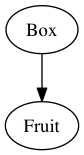

In [23]:
## Define the model
index_names = ['Box', 'Fruit']
parents = {'Box': [], 'Fruit': ['Box']}

show_dag_image(index_names, parents)


In [48]:
states = {'Box': ['Box1', 'Box2'], 
          'Fruit': ['Apple', 'Orange', 'Banana']}

cardinalities = [len(states[a]) for a in index_names]

# Conditional Probability Tables
cp_tables = {('Box'): [0.5, 0.5],
             ('Fruit', 'Box'): [[10./15, 4./15, 1./15],[2./10, 6./10, 2./10]]
            }

# Initialize the correct index order for strided access by computing the necessary permutations
theta = make_cp_tables(index_names, cardinalities, cp_tables)

visible_names = []
eng = Engine(index_names, visible_names, parents, cardinalities, theta)


What is the probability of choosing a Banana?

Compute the marginal $p(\text{Fruit}) = \sum_{\text{Box}} p(\text{Fruit}|\text{Box}) p(\text{Box})$

In [49]:
# Using the BNJNB
eng.propagate()
idx = index_names_to_num(index_names, ['Fruit'])
print(eng.compute_marginal(idx))

# Independent verification 
print(marginalize(multiply(theta, [0,1]), idx,cardinalities))


[[ 0.43333333  0.43333333  0.13333333]]
[[ 0.43333333  0.43333333  0.13333333]]


Given a banana is chosen, what is the probability that Alice chose Box1?

In [60]:
def make_evidence(ev, index_names, cardinalities, states):
    
    var_names = list(ev.keys())
    nums = index_names_to_num(index_names, var_names)
    osize = [cardinalities[n] for n in nums]
    idx = list(nums)
    shape = clique_shape(cardinalities,idx)

    C = np.zeros(shape=shape)
    N = len(index_names)

    conf = [0]*N
    for key in var_names:
        val = ev[key]
        s = states[key].index(val)
        n = index_names_to_num(index_names, [key])[0]

        conf[n] = s

    #print(conf)
    C[tuple(conf)] = 1
        
    return C
 

In [68]:
#ev = {'Fruit': 'Orange', 'Box': 'Box1'}
ev = {'Fruit': 'Orange'}

visible_names = list(ev.keys())
evidence = make_evidence(ev, index_names, cardinalities, states)

eng = Engine(index_names, visible_names, parents, cardinalities, theta)
eng.propagate(evidence)

idx = index_names_to_num(index_names, ['Box'])
print(eng.compute_marginal(idx))

# Independent verification 
print(normalize(multiply(theta, [0,1])[:,1]))



[[ 0.30769231]
 [ 0.69230769]]
[ 0.30769231  0.69230769]


In [58]:
cardinalities

[2, 3]

In [96]:
#ev_count = {(('Fruit', 'Apple'),('Box','Box1')): 1}
ev_names = ['Fruit','Box']
ev_counts = {('Apple','Box1'):12, ('Orange','Box2'):2, ('Banana','Box2'):5}

C = evidence_to_table(ev_names, ev_counts, index_names, cardinalities, states)

C

array([[ 12.,   0.,   0.],
       [  0.,   2.,   5.]])

In [493]:
idx = index_names_to_num(index_names, ['Fruit'])
idx

[1]

In [143]:
   
var_names = ['Fruit', 'Box']
ev_counts = sample_states(var_names, states, index_names, parents, cardinalities, theta, num_of_samples=1000)
C = evidence_to_table(var_names, ev_counts, index_names, cardinalities, states)
#eng = Engine(index_names, visible_names, parents, cardinalities, theta)

#C = evidence_to_counts(X, index_names)
print(ev_counts)
print(C)

{('Apple', 'Box2'): 103, ('Apple', 'Box1'): 335, ('Orange', 'Box2'): 300, ('Banana', 'Box2'): 111, ('Banana', 'Box1'): 32, ('Orange', 'Box1'): 119}
[[ 335.  119.   32.]
 [ 103.  300.  111.]]


In [104]:
X

{('Banana',): 1}

## Example: Two dice

Two fair die are thrown. Their sum comes up $9$. What is the face value of the first dice?

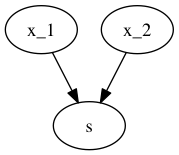

In [16]:
## Define the model
index_names = ['x_1', 'x_2', 's']
cardinalities = [6, 6, 12]
parents = {'x_1': [], 'x_2': [], 's': ['x_1', 'x_2']}

show_dag_image(index_names, parents)

#parents = {'k': [], 'i': ['k'], 'j': ['k']}
visible_names = ['s']
visibles = index_names_to_num(index_names, visible_names)


## Example: A Simple chain

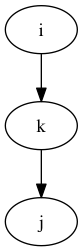

In [17]:
## Define the model
index_names = ['i', 'j', 'k']
cardinalities = [10, 20, 3]
parents = {'i': [], 'j': ['k'], 'k': ['i']}

show_dag_image(index_names, parents)

#parents = {'k': [], 'i': ['k'], 'j': ['k']}
visible_names = ['i','j']
visibles = index_names_to_num(index_names, visible_names)



## Example: Chest Clinic

The `chest clinic` model (originally known also as `Asia`) is a famous toy medical expert system example from the classical 1988 paper of Lauritzen and Spiegelhalter.
https://www.jstor.org/stable/pdf/2345762.pdf

 Shortness-of-breath (dyspnoea) may be due to tuberculosis, lung cancer or
 bronchitis, or none of them, or more than one of them. A recent visit to Asia
 increases the chances of tuberculosis, while smoking is known to be a risk factor
 for both lung cancer and bronchitis. The results of a single chest X-ray do not
 discriminate between lung cancer and tuberculosis, as neither does the presence
 or absence of dyspnoea.

Also see: http://www.bnlearn.com/documentation/man/asia.html


In this toy domain, a patient can have three diseases:

* T: Tuberculosis
* L: Lung Cancer
* B: Bronchitis 

We also have the following possible a-priori effects on contracting a disease:

* A: There is a Tuberculosis epidemic in Asia, so a visit may have an effect on Tuberculosis
* S: Smoking history is known to have an effect both on Lung cancer and Bronchitis

Logical variables may be present, for example 
* E: Either T or L or both

Symptoms or medical test results

* D: The patient can show Dyspnea: Difficult breathing; shortness of breath, depending on T,L or B 
* X: X Ray gives a positive response if either Lung Cancer or Tuberclosis, or both. B does not have a direct efect on the outcome of the X-Ray


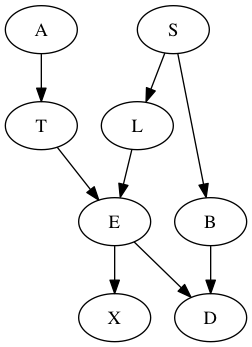

In [214]:
# [A][S][T|A][L|S][B|S][E|T:L][X|E][D|B:E]

index_names = ['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']
parents = {'A':[], 'S':[], 'T':['A'], 'L':['S'], 'B':['S'], 'E':['T','L'], 'X':['E'], 'D':['B','E']}

## A Method for systematically entering the conditional probability tables

# P(A = Yes) = 0.01
# P(S = Yes) = 0.5
# P(T=Positive | A=Yes) = 0.05
# P(T=Positive | A=No) = 0.01
# P(L=Positive | S=Yes) = 0.1
# P(L=Positive | S=No) = 0.01
# P(B=Positive | S=Yes) = 0.6
# P(B=Positive | S=No) = 0.3
# P(E=True | L=Positive, T=Positive) = 1
# P(E=True | L=Positive, T=Negative) = 1
# P(E=True | L=Negative, T=Positive) = 1
# P(E=True | L=Negative, T=Negative) = 0
# P(X=Positive | E=True) = 0.98
# P(X=Positive | E=False) = 0.05
# P(D=Positive | E=True, B=Positive) = 0.9
# P(D=Positive | E=True, B=Negative) = 0.7
# P(D=Positive | E=False, B=Positive) = 0.8
# P(D=Positive | E=False, B=Negative) = 0.1

states = {'A':['No', 'Yes'], 
          'S':['No', 'Yes'], 
          'T':['Negative','Positive'], 
          'L':['Negative','Positive'], 
          'B':['Negative','Positive'], 
          'E':['False', 'True'], 
          'X':['Negative','Positive'],
          'D':['Negative','Positive']}

cardinalities = [len(states[a]) for a in index_names]

# Conditional Probability Tables
cp_tables = {('A'): [0.99, 0.01],
             ('S'): [0.5, 0.5],
             ('T','A'): [[0.99, 0.01],[0.95,0.05]],
             ('L','S'): [[0.99, 0.01],[0.9,0.1]],
             ('B','S'): [[0.7,0.3],[0.4, 0.6]],
             ('E','T','L'): [[[1.,0.],[0.,1.]] , [[0.,1.],[0.,1.]]],
             ('X','E'): [[0.95, 0.05], [0.02, 0.98]],
             ('D','B','E'):[[[0.9,0.1],[0.2,0.8]],[[0.3,0.7],[0.1,0.9]]]
            }

# Todo: write a converter from a standard bn format

theta = make_cp_tables(index_names, cardinalities, cp_tables)
show_dag_image(index_names, parents)

visible_names = []
eng = Engine(index_names, visible_names, parents, cardinalities, theta)

In [135]:
topo_order = topological_order(index_names, parents)
topo_order

[1, 6, 3, 4, 2, 5, 0, 7]

In [ ]:
E_S_new = eng.propagate(X)

In [ ]:
P = multiply(eng.theta, range(len(cardinalities)))
P /= marginalize(P, visibles, cardinalities)
E_S = X*P

In [ ]:
n = 7


print(marginalize(E_S, eng.Pot[n], cardinalities).flatten())
print(E_S_new[n].flatten())

In [16]:
theta[2].shape

(2, 1, 2, 1, 1, 1, 1, 1)

['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']


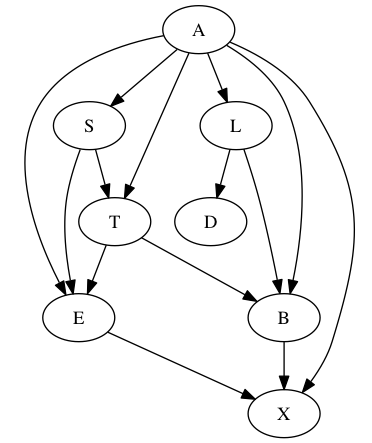

{'A': [], 'S': ['A'], 'T': ['S', 'A'], 'L': ['A'], 'B': ['A', 'T', 'L'], 'E': ['T', 'S', 'A'], 'X': ['E', 'B', 'A'], 'D': ['L']}
[2, 4, 3, 5, 3, 4, 5, 3]
{'A': ['A_state_0', 'A_state_1'], 'S': ['S_state_0', 'S_state_1', 'S_state_2', 'S_state_3'], 'T': ['T_state_0', 'T_state_1', 'T_state_2'], 'L': ['L_state_0', 'L_state_1', 'L_state_2', 'L_state_3', 'L_state_4'], 'B': ['B_state_0', 'B_state_1', 'B_state_2'], 'E': ['E_state_0', 'E_state_1', 'E_state_2', 'E_state_3'], 'X': ['X_state_0', 'X_state_1', 'X_state_2', 'X_state_3', 'X_state_4'], 'D': ['D_state_0', 'D_state_1', 'D_state_2']}


(2, 1, 1, 1, 1, 1, 1, 1)

In [18]:
#index_names = [a for a in set(['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D'])]
index_names = ['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']
parents = random_parents(index_names)
show_dag_image(index_names, parents)

visible_names = ['X','A','B']
visibles = index_names_to_num(index_names, visible_names)

families = make_families(index_names, parents)
cardinalities = random_cardinalities(index_names)
states = random_states(index_names, cardinalities)
Clique, elim_seq = make_cliques(families, cardinalities, visibles)

gamma = 0.01
theta = random_cp_tables(index_names, cardinalities, parents, gamma)
X = random_observations(cardinalities, visibles)

print(parents)
print(cardinalities)
print(states)
theta[0].shape

In [19]:

nums = index_names_to_num(index_names, visible_names)
osize = [cardinalities[n] for n in nums]
X = np.random.choice(range(10), size = osize)

X2 = make_observations(index_names, cardinalities, visible_names, X)


NameError: name 'make_observations' is not defined

In [75]:
X.shape

(3, 1, 1, 1, 5, 1, 5, 1)

In [77]:
X2.shape

(3, 1, 1, 1, 5, 1, 5, 1)

In [72]:
clique_shape(cardinalities, [1,0,7])

[3, 4, 1, 1, 1, 1, 1, 5]

In [73]:
print(index_names)
index_names_to_num(index_names, ['A','D','S','X'])

['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']


[0, 7, 1, 6]

In [134]:
shape = clique_shape(cardinalities, [7, 0,1,2,4])
clique_prior_marginal(cardinalities, shape)

75.0

The correct initialization of probability tables is important but can be tricky.

We define three catalogs:

parents: Keys are node names, the values are lists of parents. When a node does not have any parent, the corresponding list is empty.

states: Keys are node names, values are the labels of each state of a random variable.

cp_tables: Keys are tuples of form (n,parents[n]), Values are probability values. The order of the
variables defining a key is important in matching the correct probabilities to state combinations.

See the conditional probability definition for p(D|B, E). The key is (D,B,E), the probabilities are defined on a tree
in the reverse order, i.e starting from E, then B, then D.

Reshape the tables

In [5]:
theta = [[]]*G.nVertex

for c in cp_tables:
    n = G.name2idx[c[0]]
    idx = list(reversed(G.nodenames2idx(c)))
    theta[n] = np.einsum(np.array(cp_tables[c]), idx, sorted(idx)).reshape(G.clique_shape(idx))

In [86]:
P = multiply(theta,range(G.nVertex))

In [95]:
marginalize(P, [7], G)

array([[[[[[[[ 0.5640294,  0.4359706]]]]]]]])

## Example 4: A random Model

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']


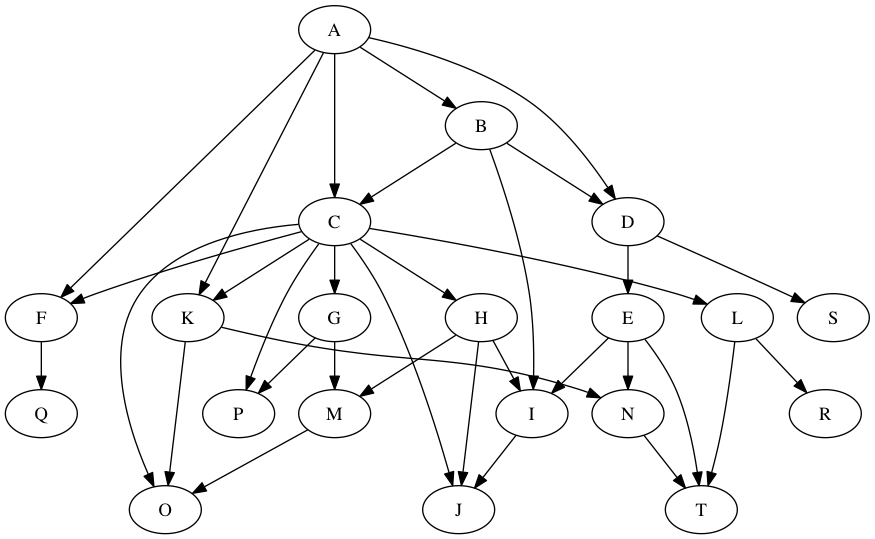

In [170]:
index_names, parents, cardinalities, states = random_model(20, max_indeg=5)
show_dag_image(index_names, parents)

#theta = make_random_cp_tables(index_names, cardinalities, parents, gamma=0.01)    

visible_names = index_names[-4:]

In [168]:
families = make_families(index_names, parents)
visibles = make_visibles(index_names, visible_names)

Clique, elim_seq = make_cliques(families, cardinalities, visibles, show_graph=False)


print(elim_seq)
print(Clique)

[5, 12, 14, 11, 13, 9, 8, 10, 17, 16, 19, 0, 15, 1, 2, 3, 4, 6, 7, 18]
[{0, 1, 5}, {2, 4, 12}, {1, 2, 11, 14}, {1, 2, 11, 7}, {10, 18, 13, 7}, {8, 9, 6, 15}, {0, 8, 6, 15}, {18, 10, 4, 6, 7}, {6, 15, 16, 17, 18, 19}, {3, 6, 15, 16, 18, 19}, {2, 3, 6, 15, 18, 19}, {0, 1, 2, 3, 6, 15}, {1, 2, 3, 6, 15, 18}, {1, 2, 3, 4, 6, 7, 18}]


## Example 5: A Hidden Markov Model

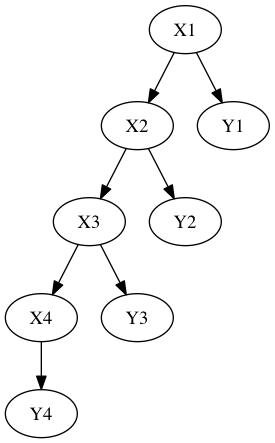

In [169]:
index_names = ['X1', 'X2', 'X3', 'X4', 'Y1', 'Y2', 'Y3', 'Y4']
parents = {'X1':[], 'Y1':['X1'], 'X2':['X1'], 'Y2':['X2'], 'X3':['X2'], 'Y3':['X3'], 'X4':['X3'], 'Y4':['X4'] }
cardinalities = [2]*8

show_dag_image(index_names, parents)


# Building an inference engine

In [ ]:
#index_names = [a for a in set(['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D'])]
index_names = ['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']
visible_names = ['X', 'A', 'D']
parents = random_parents(index_names)
cardinalities = random_cardinalities(index_names)
states = random_states(index_names, cardinalities)

show_dag_image(index_names, parents)


families = make_families(index_names, parents)
visibles = make_visibles(index_names, visible_names)


Clique, elim_seq = make_cliques(families, cardinalities, visibles=None)

gamma = 0.01
theta = make_random_cp_tables(index_names, cardinalities, parents, gamma)


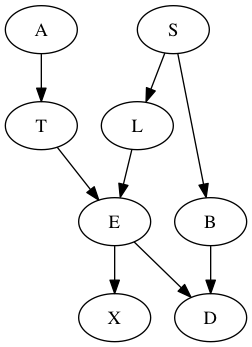

In [359]:
index_names = ['A', 'S', 'T', 'L', 'B', 'E', 'X', 'D']
parents = {'A':[], 'S':[], 'T':['A'], 'L':['S'], 'B':['S'], 'E':['T','L'], 'X':['E'], 'D':['B','E']}
show_dag_image(index_names, parents)
cardinalities = [2,2,2,2,2,2,2,2]

visible_names = ['A', 'X', 'D']
visibles = make_visibles(index_names, visible_names)
## Generate random potentials
gamma = 0.01
theta = make_random_cp_tables(index_names, cardinalities, parents, gamma)

X = random_observations(cardinalities, visibles)

eng = Engine(index_names, visible_names, parents, cardinalities, theta) 

In [ ]:
eng.propagate()
eng.compute_marginal([5,2])

In [360]:
X = eng.sample_counts(visibles, num_of_samples=1000)

In [362]:
X

array([[[[[[[[ 29,  23],
             [134,  85]]]]]]],






       [[[[[[[104,  36],
             [484, 105]]]]]]]])

In [363]:
eng.compute_marginal(visibles)

array([[[[[[[[ 0.03980236,  0.02064799],
             [ 0.13923981,  0.06172193]]]]]]],






       [[[[[[[ 0.12894433,  0.03705469],
             [ 0.45607671,  0.11651218]]]]]]]])

In [322]:
E_S_new = eng.compute_ESS()

In [323]:
P = multiply(eng.theta, range(len(cardinalities)))
E_S = P

In [105]:
E_S_new = eng.propagate(X)


In [324]:
P = multiply(eng.theta, range(len(cardinalities)))
Px = marginalize(P, visibles, cardinalities)
P /= Px
E_S = X*P

In [325]:
Px

array([[[[[[[[ 0.07058016,  0.06886115],
             [ 0.02652879,  0.05208144]]]]]]],






       [[[[[[[ 0.10527259,  0.16839005],
             [ 0.15470018,  0.35358565]]]]]]]])

In [317]:
SepX

array([[[[[[[[ 0.15081207,  0.13275136],
             [ 0.42118347,  0.01969353]]]]]]],






       [[[[[[[ 0.05735447,  0.05056736],
             [ 0.16014664,  0.0074911 ]]]]]]]])

In [122]:
n = 0


print(marginalize(E_S, eng.Pot[n], cardinalities).flatten())
print(E_S_new[n].flatten())

[ 0.70165921  0.29834079]
[ 0.70165921  0.29834079]


# Obsolete

In [2]:
  
class DAG_Model:
    def __init__(self, index_names, parents, cardinalities):
        ## Preprocessing the model
        nVertex = len(index_names)
        name2idx = {name: i for i,name in enumerate(index_names)}

        ## Build Graph data structures
        # Adjacency matrix
        adj = np.zeros((nVertex, nVertex), dtype=int)
        for i_name in parents.keys():
            i = name2idx[i_name]
            for m_name in parents[i_name]:
                j = name2idx[m_name]
                adj[i, j] = 1
                
        # Family, Parents and Children
        fa = [[]]*nVertex
        pa = [[]]*nVertex
        ch = [[]]*nVertex
        for n in range(nVertex):
            p = find(adj[n,:])
            pa[n] = p
            fa[n] = [n]+p
            c = find(adj[:,n])
            ch[n] = c
              
        # Sizes
        size = [[]]*nVertex
        for n in range(nVertex):
            size[n] = [1]*nVertex
            for j in fa[n]:
                size[n][j] = cardinalities[j]

        self.nVertex = nVertex
        self.name2idx = name2idx
        self.index_names = index_names
        self.parents = parents
        self.adj = adj
        self.pa = pa
        self.fa = fa
        self.ch = ch

        self.cardinalities = cardinalities
        self.size = size
    def nodename2idx(self, name):
        return self.name2idx[name]
    def nodenames2idx(self, names):
        return [self.name2idx[nm] for nm in names] 
    def nodenames2idxset(self, names):
        return set([self.name2idx[nm] for nm in names])
    def clique_shape(self, idxs):
        '''Returns the shape vector for a clique potential on given indices'''
        shape = [1]*self.nVertex
        for i in idxs:
            shape[i] = cardinalities[i]
        return shape
    def clique_compact_shape(self, idxs):
        '''Returns the shape vector for a clique potential on given indices'''
        shape = [1]*len(idxs)
        for u,i in enumerate(idxs):
            shape[u] = cardinalities[i]
        return shape
    def show_image(self, imstr='file.png'):
        A = pgv.AGraph(directed=True)

        for i_n in self.index_names:
            A.add_node(self.nodename2idx(i_n), label=i_n)
            for j_n in self.parents[i_n]:
                A.add_edge(self.nodename2idx(j_n), self.nodename2idx(i_n))

        A.layout(prog='dot')
        A.draw(imstr)
        return imstr
    def show_ug_image(self, UG, imstr='file.png'):
        A = pgv.AGraph(directed=False)

        for i_n in range(UG.shape[0]):
            A.add_node(i_n, label=i_n)
            for j_n in find(UG[i_n,:]):
                if j_n>i_n:
                    A.add_edge(j_n, i_n)

        A.layout(prog='dot')
        A.draw(imstr)
        return imstr
    def make_cliques(self, visibles=None, show_graph=False):
        if visibles is None:
            C = G.fa
        else:
            C = G.fa+[visibles]
           
        # Moral Graph
        MG = np.zeros((G.nVertex, G.nVertex)) 

        for F in C:
            for edge in combinations(F,2):
                MG[edge[0], edge[1]] = 1  
                MG[edge[1], edge[0]] = 1  

        if show_graph:
            imf = self.show_ug_image(MG,imstr='MG.png')
            display(Image(imf))

                
        elim = []
        Clique = []
        N = self.nVertex
        visited = [False]*N

        # Find an elimination sequence
        # Based on greedy search 
        # Criteria, select the minimum induced clique size
        for j in range(N):

            min_clique_size = np.inf
            min_idx = -1
            for i in range(N):
                if not visited[i]:
                    neigh = find(MG[i,:])
                    nm = np.prod(self.clique_shape(neigh+[i]))

                    if min_clique_size > nm:
                        min_idx = i
                        min_clique_size = nm

            neigh = find(MG[min_idx,:])
            temp = set(neigh+[min_idx])

            is_subset = False
            for CC in Clique:
                if temp.issubset(CC):
                    is_subset=True
            if not is_subset:
                Clique.append(temp)

            # Remove the node from the moral graph
            for edge in combinations(neigh,2):
                MG[edge[0], edge[1]] = 1
                MG[edge[1], edge[0]] = 1

            MG[min_idx,:] = 0
            MG[:, min_idx] = 0
            elim.append(min_idx)
            visited[min_idx] = True
            if show_graph:
                imf = self.show_ug_image(MG,imstr='MG'+str(j)+'.png')
                display(Image(imf))
            
        return elim, Clique    
    
   

In [ ]:
    def propagate_old(self, X=[]):
        #print('Collection Stage')
        E_S = dict()
            
        for c in reversed(self.order):
            #print('Processing Clique', c, Clique[c])   
            self.CliquePot[c] = np.ones(clique_shape(self.cardinalities, self.Clique[c]))
            for p in self.receive_from[c]:
                self.CliquePot[c] *= self.SeparatorPot[(p,c)]

            #for th in find(Clique2Pot[c, :]):
            #    print('Multiply ', Pot[th])

            idx = find(self.Clique2Pot[c, :])
            if idx:
                self.CliquePot[c] *= multiply(self.theta, idx) 
                #print(CliquePot[c].shape)

            if not is_root(c, self.parent):
                idx = self.Clique[self.parent[c]].intersection(self.Clique[c])
                self.SeparatorPot[(c,self.parent[c])] = marginalize(self.CliquePot[c], idx, self.cardinalities)
                #print('Compute Separator potential of', c, 'with', parent[c],'on', Clique[parent[c]].intersection(Clique[c]))

        SepX = marginalize(self.CliquePot[self.RootClique], visibles, self.cardinalities)
        if X:    
            # Note: Take care of zero divide
            self.CliquePot[self.RootClique] *= X/SepX
            #print('*Compute Separator potential with observations', visibles)
            #print('*Multiply Observations', visibles)
            #print('*Divide Separator by separator potentials', visibles)

        for n in find(self.Clique2Pot[self.RootClique, :]):
            #print(n)
            #print('Compute Marginal ', Pot[n])
            E_S[n] = marginalize(self.CliquePot[self.RootClique], self.Pot[n], self.cardinalities)

        #print('Distribution Stage')
        for c in self.order[1:]:
            #print('Processing Clique', c, Clique[c])
            idx = self.Clique[self.parent[c]].intersection(self.Clique[c])
            self.CliquePot[c] *= marginalize(self.CliquePot[self.parent[c]], idx, self.cardinalities)/self.SeparatorPot[(c,self.parent[c])]
            #print('Compute Separator potential of', parent[c], 'with', c, 'on', Clique[parent[c]].intersection(Clique[c]))
            #print('Divide by the old separator potential and multiply with the clique potential')

            for n in find(self.Clique2Pot[c, :]):
                #print(n)
                #print('Compute Marginal ', Pot[n])
                #E_S[n] = normalize(marginalize(self.CliquePot[c], self.Pot[n], self.G), axis=n)
                E_S[n] = marginalize(self.CliquePot[c], self.Pot[n], self.cardinalities)
                
        return E_S, SepX

In [104]:
np.random.gamma(shape=[0,1,1,0])

array([ 0.        ,  0.51149101,  0.60008427,  0.        ])

In [188]:
a = np.array([[[1,2,3],[3,4]]])

In [196]:
theta[4].shape

(5,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1)

In [205]:
sz = [1,3,4,2,1,1]
a = np.random.rand(*sz)

In [224]:
idx = [0,1,3,(0,1),0,0]